### Get plots on multiclass logistic regression on CIFAR-10.

In [18]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"   # must be set first
os.environ["OMP_NUM_THREADS"] = "1"


In [19]:
# ----- basic imports -----------------------------------------
import jax, jax.numpy as jnp, jax.random as jr
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ----- CIFAR-10 ------------------------------------------------
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

def _load(split: str):
    ds = CIFAR10(root="~/data", train=(split == "train"),
                 download=True, transform=ToTensor())
    imgs   = jnp.stack([jnp.array(t[0]).reshape(-1) for t in ds]) / 255.0
    labels = jnp.array([t[1] for t in ds])
    onehot = jax.nn.one_hot(labels, 10)
    return imgs, onehot

x_train, y_train = _load("train")
x_test,  y_test  = _load("test")

n_features, n_classes = x_train.shape[1], 10

# ----- model params (all-zeros init, paper) -------------------
W0 = jnp.zeros((n_features, n_classes))
b0 = jnp.zeros(n_classes)
flat0 = jnp.concatenate([W0.ravel(), b0])

def _unflat(v):
    W = v[:-n_classes].reshape(n_features, n_classes)
    b = v[-n_classes:]
    return W, b

l2_mu = 1e-3                       # λ = μ in the paper (strong convexity)

@jax.jit
def forward(params, x):
    W, b = _unflat(params)
    return jax.nn.log_softmax(x @ W + b, axis=-1)

@jax.jit
def base_loss(params, batch):
    x, y = batch
    ce = -jnp.mean(jnp.sum(y * forward(params, x), axis=1))
    l2 = 0.5 * l2_mu * jnp.sum(params**2)
    return ce + l2


In [20]:
# ----- mini-batch oracle -------------------------------------
BATCH = 256
def next_batch(key):
    idx = jr.choice(key, x_train.shape[0], (BATCH,), replace=False)
    return x_train[idx], y_train[idx]

# ----- global counter ----------------------------------------
oracle_calls = 0

def counted_loss(params, key):
    """1 oracle call: forward pass (used by LS probes)."""
    global oracle_calls
    oracle_calls += 1
    return base_loss(params, next_batch(key))

def counted_grad(params, key):
    """2 oracle calls: forward + backward."""
    global oracle_calls
    oracle_calls += 2
    return jax.grad(base_loss)(params, next_batch(key))

def counted_hvp(params, vec, key):
    """2 more calls: forward + backward of grad·vec (jvp)."""
    global oracle_calls
    oracle_calls += 2
    return jax.jvp(lambda p: counted_grad(p, key), (params,), (vec,))[1]


In [21]:
import optimizers.mrcg as mrcg

# --- override scaling_selection to count Hv-products ----------
def scaling_selection_cnt(g, loss_at_params, params, sigma, key,
                          constant_learning_rate=True):
    Hg = counted_hvp(params, g, key)     # uses counted_hvp
    dot = jnp.dot(g, Hg)
    norm_g = jnp.linalg.norm(g)
    s_CG = norm_g**2 / dot
    s_MR = dot / jnp.linalg.norm(Hg)**2
    s_GM = jnp.sqrt(s_CG * s_MR)
    if constant_learning_rate:
        s_lpc_min = s_lpc_max = 1.0 / sigma
    else:
        s_lpc_min = (1.0 / sigma) * jr.uniform(key, ())
    if dot > sigma * norm_g**2:
        s_choice = jr.choice(key, a=jnp.array([s_CG, s_MR, s_GM]))
        return -s_choice * g, "SPC"
    elif 0.0 < dot < sigma * norm_g**2:
        slpc = jr.uniform(key, (), s_lpc_min, 1.0 / sigma)
        return -slpc * g, "LPC"
    else:
        snc = jr.uniform(key, (), s_lpc_min, s_lpc_max)
        return -snc * g, "NC"

mrcg.scaling_selection = scaling_selection_cnt   # monkey-patch

# --- wrap mrcg_step so it uses counted_grad -------------------
def mrcg_step_cnt(state: mrcg.MRCGState) -> mrcg.MRCGState:
    grad = counted_grad(state.params, state.key)
    key, subkey = jr.split(state.key)
    p, flag = scaling_selection_cnt(grad, state.loss_at_params,
                                    state.params, state.sigma, subkey)
    if flag in ("SPC", "LPC"):
        alpha = mrcg.backtracking_LS(state.loss_at_params, state.key,
                                     state.theta_bt, state.rho,
                                     state.params, grad, p)
    else:
        alpha = mrcg.forward_backward_LS(state.loss_at_params, state.key,
                                         state.theta_fb, state.rho,
                                         state.params, grad, p)
    new_params = state.params + alpha * p
    return mrcg.MRCGState(new_params, state.loss_at_params, key,
                          state.sigma, state.rho, state.theta_bt,
                          state.theta_fb, state.iteration + 1)

mrcg.mrcg_step = mrcg_step_cnt                   # monkey-patch


NES: 100%|██████████| 500/500 [01:03<00:00,  7.90it/s]


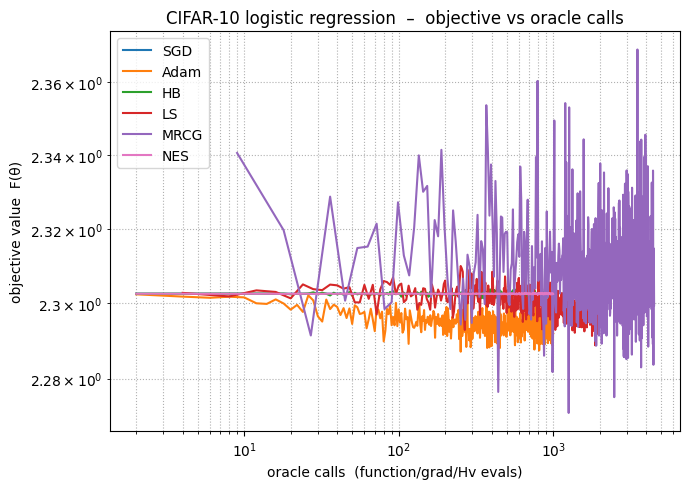

In [24]:
# ----- import other optimisers --------------------------------
from optimizers.gd  import SGDState, sgd_step
from optimizers.HB   import hb_init, hb_step
from optimizers.adamw import adamw_init, adamw_step
from optimizers.LS_GD import ls_init, ls_step
from optimizers.NES import nes_init, nes_step

optims   = ["SGD", "Adam", "HB", "LS", "MRCG", "NES"]
iters    = 500                                # ≈ 1 e5 oracle calls
histories = {}

registry = {
    "SGD":  (lambda p,k: SGDState(p, counted_loss, 1/300., k),   sgd_step,"tab:blue"),
    "HB":   (lambda p,k: hb_init(p, counted_loss, 1/300., k, beta=0.9), hb_step,"tab:green"),
    "Adam": (lambda p,k: adamw_init(p, counted_loss, 1e-3, k),   adamw_step,"tab:orange"),
    "LS":   (lambda p,k: ls_init(p, counted_loss, k, rho=1e-4, theta=0.5), ls_step,"tab:red"),
    "NES":  (lambda p,k: nes_init(p, counted_loss, 1/300., k),   nes_step,"tab:pink"),
    "MRCG": (lambda p,k: mrcg.MRCGState(p, counted_loss, k, sigma=1e-3,
                                        rho=1e-4, theta_bt=0.5, theta_fb=0.5),
             mrcg_step_cnt, "tab:purple"),
}

for name in optims:
    oracle_calls = 0
    key = jr.PRNGKey(hash(name) & 0xFFFF)
    state = registry[name][0](flat0, key)
    step_fn, colour = registry[name][1:]
    losses, calls = [], []
    for _ in tqdm(range(iters), desc=name):
        state = step_fn(state)                          # do work
        losses.append(counted_loss(state.params, state.key))
        calls.append(oracle_calls)
    histories[name] = dict(loss=jnp.asarray(losses),
                           calls=jnp.asarray(calls),
                           colour=colour)

# ----- plot ----------------------------------------------------
plt.figure(figsize=(7,5))
for name, rec in histories.items():
    plt.plot(rec["calls"].copy(), jnp.clip(rec["loss"],1e-12).copy(),
             label=name, color=rec["colour"])
plt.xscale("log"); plt.yscale("log")
plt.xlabel("oracle calls  (function/grad/Hv evals)")
plt.ylabel("objective value  F(θ)")
plt.title("CIFAR-10 logistic regression  –  objective vs oracle calls")
plt.grid(True, which="both", ls=":")
plt.legend(); plt.tight_layout(); plt.show()
